In [8]:
from google.cloud import bigquery
import pandas as pd
from tqdm import tqdm
from concurrent.futures import TimeoutError
import os
import numpy as np
import json
from pathlib import Path
import glob

cache_file = lambda filename: Path().resolve().joinpath(*['cache', filename])

"""BIG QUERY FUNCTIONS"""

def client():
    """require a bigquery project and credentials, save in json in root main directory"""
    credsfile = Path().resolve().joinpath('antiechochambers-1ba7f7f4c68e.json')
    return bigquery.Client.from_service_account_json(credsfile)

def jobConfig():
    config = bigquery.QueryJobConfig()
    config.query_parameters = (bigquery.ScalarQueryParameter('size', 'INT64', 10),)
    config.use_legacy_sql = False
    config.maximum_bytes_billed = int(5e9)
    
    return config

def run_job(query):
    print('Submitting query')
    j = client().query(query=query, job_config=jobConfig())
    with tqdm() as pbar:
        while True:
            try:
                j.result(timeout=1)
            except TimeoutError:                
                pbar.update(1)
            else:
                break
    return j

def fetchQuery(query):
    j = run_job(query)
    df = j.to_dataframe()
    
    return df

def fetchSubredditData(subreddit):
    """should create bot table to call on"""
    query = f"""SELECT subreddit, author, COUNT(created_utc) as weight
                FROM `fh-bigquery.reddit_comments.2017_06`
                WHERE author in (SELECT author
                                 FROM `aerobic-datum-126519.sms_18_sample_subreddits.mainSubInCounts`
                                 WHERE (subreddit = '{subreddit}') AND (authorInCount > 2) AND
                                         author not in (SELECT author
                                                         FROM `fh-bigquery.reddit_comments.bots_201505`)
                                        AND (lower(author) NOT LIKE '%bot%')
                                        AND (author NOT LIKE 'JlmmyButler')
                                        AND (author NOT LIKE 'TotesMessenger'))
                GROUP BY subreddit, author
                HAVING weight > 2"""

    data = fetchQuery(query)
    
    return data

In [4]:
import time

def get_node_ids_dict(edgelist):
    node_ids = list(edgelist.subreddit.unique()) + list(edgelist.author.unique())
    return dict(zip(node_ids, range(len(node_ids))))

def get_edges(edgelist, subreddit):
    node_ids_dict = get_node_ids_dict(edgelist)
    #start = time.time()
    edgelist = edgelist[edgelist['subreddit']!=subreddit]
    edges = pd.DataFrame({'subreddit':edgelist.subreddit.map(lambda x: node_ids_dict[x]),
                          'author':edgelist.author.map(lambda x: node_ids_dict[x]),
                          'weight':edgelist.weight})
    edges = edges[['subreddit','author','weight']]
    #end = time.time()

    #elapsed = end-start
    #print(f'that took {elapsed} seconds')
    
    return edges

### Projecting unipartite network

In [5]:
import numpy as np
from scipy import sparse

def project_unipartite_network(edgelist, subreddit, row='subreddit',col='author'):
    edges = get_edges(edgelist, subreddit)
    edges['value'] = 1
    row_ind = np.array(edges[row])
    col_ind = np.array(edges[col])
    data = np.array(edges['value'], dtype=float)
    mat_coo = sparse.coo_matrix((data, (row_ind, col_ind)))
    mat_coo.sum_duplicates()
    csr = mat_coo.tocsr()
    #csr.sum_duplicates()

    sub_net = csr.dot(csr.T).tolil()
    sub_net.setdiag(0)
    
    return sub_net

### network density and degree histogram

In [6]:
def get_network_density(sub_net):
    assert sub_net.shape[0]==sub_net.shape[1], 'matrix is not square'

    N = sub_net.shape[0]
    E = sub_net.getnnz()

    return (E-N+1)/(N*(N-3)+2)
    
def get_degrees(network, network_type):
    degrees = pd.DataFrame(np.count_nonzero(network.todense(), axis=1), columns=[f'{network_type}_degrees'])
    weighted_degrees = pd.DataFrame(network.sum(axis=1),columns=[f'{network_type}_weighted_degrees'])
    
    return degrees, weighted_degrees

In [7]:
def get_stats_df(data, subreddit):
    #print('getting subreddit network...')
    sub_net = project_unipartite_network(data, subreddit)
    subreddit_density = get_network_density(sub_net)
    #subreddit_degrees, subreddit_weighted_degrees = get_degrees(sub_net, 'subreddit')
    
    #print('getting author network...')
    author_net = project_unipartite_network(data, subreddit,row='author', col='subreddit')
    author_density = get_network_density(author_net)
    #author_degrees, author_weighted_degrees = get_degrees(author_net, 'author')

    print('compiling stats...')
    stats = {'sub_counts':data.subreddit.value_counts().describe(),
             'author_counts':data.author.value_counts().describe(),
             'bipartite_edge_weights':data.weight.describe(),
             'sub_net_density':subreddit_density,
             #'subreddit_degrees':subreddit_degrees['subreddit_degrees'].describe(),
             #'subreddit_weighted_degrees':subreddit_weighted_degrees['subreddit_weighted_degrees'].describe(),
             'author_net_density':author_density,
             #'author_degrees':author_degrees['author_degrees'].describe(),
             #'author_weighted_degrees':author_weighted_degrees['author_weighted_degrees'].describe()
            }

    stats_df = pd.DataFrame.from_dict(stats)
    stats_df.index.name = 'stat'
    stats_df['subreddit'] = subreddit
    return stats_df

In [18]:
td_data = fetchSubredditData("The_Donald")
td_stats_df = get_stats_df(td_data, "The_Donald")

fetching data...
Submitting query


0it [00:00, ?it/s]


getting subreddit network...
that took 0.16529512405395508 seconds
getting author network...
that took 0.1575329303741455 seconds
compiling stats...


In [22]:
stats_dfs = pd.concat([cmv_stats_df, td_stats_df],axis=0,keys=['cmv','td'])

In [29]:
stats_dfs.to_csv('network_stats.csv')

In [6]:
cmv_data = fetchSubredditData("changemyview")
cmv_stats_df = get_stats_df(cmv_data, "changemyview")

Submitting query


4it [00:05,  1.31s/it]


getting subreddit network...
that took 0.04991888999938965 seconds
getting author network...
that took 0.050752878189086914 seconds
compiling stats...


In [7]:
cmv_stats_df

,author_counts,author_net_density,bipartite_edge_weights,sub_counts,sub_net_density
count,3556.000000,0.059909,32882.000000,4047.000000,0.018425
mean,9.246907,0.059909,15.464662,8.125031,0.018425
std,9.475191,0.059909,42.176850,66.610722,0.018425
min,1.000000,0.059909,3.000000,1.000000,0.018425
25%,3.000000,0.059909,4.000000,1.000000,0.018425
50%,6.000000,0.059909,6.000000,2.000000,0.018425
75%,12.000000,0.059909,13.000000,4.000000,0.018425
max,96.000000,0.059909,2467.000000,3556.000000,0.018425


### dropping weak ties

In [31]:
subreddit = "changemyview"
data = fetchSubredditData(subreddit)

Submitting query


0it [00:00, ?it/s]


In [32]:
data.head()

,subreddit,author,weight
0,de,Kelsig,3
1,de,weedtese,3
2,de,Feroc,3
3,de,krimin_killr21,3
4,de,tastetherainbowmoth,4


In [78]:
def get_subset(data, n=10, defaults=None):
    sub_counts = data.subreddit.value_counts()
    author_counts = data.author.value_counts()

    keep_subs = sub_counts[sub_counts>=n].index
    keep_authors = author_counts[author_counts>=n].index
    
    subset = data.copy()
    
    subset=subset[(subset['subreddit'].isin(keep_subs))&
              (subset['author'].isin(keep_authors))&
              (subset['weight']>=n)]
    
    if defaults:
        subset=subset[~subset.isin(defaults)]
    
    return subset

In [58]:
cmv_subset = get_subset(cmv_data, n=10)

In [59]:
cmv_subset.shape

(6684, 3)

In [60]:
cmv_subset_stats = get_stats_df(cmv_subset, "changemyview")

getting subreddit network...
that took 0.014419078826904297 seconds
getting author network...
that took 0.032124996185302734 seconds
compiling stats...


In [61]:
cmv_subset_stats

,author_counts,author_net_density,bipartite_edge_weights,sub_counts,sub_net_density
count,1186.000000,0.197052,6684.000000,493.000000,0.149074
mean,5.635750,0.197052,36.471275,13.557809,0.149074
std,5.341553,0.197052,67.963827,42.663878,0.149074
min,1.000000,0.197052,10.000000,1.000000,0.149074
25%,3.000000,0.197052,13.000000,3.000000,0.149074
50%,5.000000,0.197052,19.000000,5.000000,0.149074
75%,7.000000,0.197052,35.000000,10.000000,0.149074
max,129.000000,0.197052,2467.000000,600.000000,0.149074


In [83]:
cmv_subset.subreddit.value_counts().sort_values(ascending=False).head(10)

changemyview           505
politics               293
AskMen                  62
Libertarian             62
AdviceAnimals           60
CringeAnarchy           54
technology              52
nba                     49
NoStupidQuestions       44
PoliticalDiscussion     42
Name: subreddit, dtype: int64

In [84]:
td_data = fetchSubredditData("The_Donald")
td_subset = get_subset(td_data, n=10, defaults=defaults_list)

Submitting query


0it [00:00, ?it/s]


In [85]:
td_data.shape

(130977, 3)

In [70]:
td_subset_stats = get_stats_df(td_subset, "The_Donald")
td_subset_stats

getting subreddit network...
that took 0.036611080169677734 seconds
getting author network...
that took 0.025936126708984375 seconds
compiling stats...


,author_counts,author_net_density,bipartite_edge_weights,sub_counts,sub_net_density
count,3416.000000,0.132256,18173.000000,1123.000000,0.060784
mean,5.319965,0.132256,39.539757,16.182547,0.060784
std,4.758141,0.132256,74.024180,82.809176,0.060784
min,1.000000,0.132256,10.000000,1.000000,0.060784
25%,3.000000,0.132256,13.000000,2.000000,0.060784
50%,4.000000,0.132256,19.000000,4.000000,0.060784
75%,7.000000,0.132256,36.000000,9.000000,0.060784
max,175.000000,0.132256,2467.000000,2135.000000,0.060784


In [87]:
td_subset.subreddit.value_counts().sort_values(ascending=False).head(10)

The_Donald        2135
politics           723
CringeAnarchy      265
nba                196
conspiracy         182
KotakuInAction     160
AdviceAnimals      141
pcmasterrace       128
Conservative       107
PoliticalHumor     103
Name: subreddit, dtype: int64

### removing defaults

In [72]:
defaults = """
/r/announcements/
/r/Art/
/r/AskReddit/
/r/askscience/
/r/aww/
/r/blog/
/r/books/
/r/creepy/
/r/dataisbeautiful/
/r/DIY/
/r/Documentaries/
/r/EarthPorn/
/r/explainlikeimfive/
/r/food/
/r/funny/
/r/Futurology/
/r/gadgets/
/r/gaming/
/r/GetMotivated/
/r/gifs/
/r/history/
/r/IAmA/
/r/InternetIsBeautiful/
/r/Jokes/
/r/LifeProTips/
/r/listentothis/
/r/mildlyinteresting/
/r/movies/
/r/Music/
/r/news/
/r/nosleep/
/r/nottheonion/
/r/OldSchoolCool/
/r/personalfinance/
/r/philosophy/
/r/photoshopbattles/
/r/pics/
/r/science/
/r/Showerthoughts/
/r/space/
/r/sports/
/r/television/
/r/tifu/
/r/todayilearned/
/r/UpliftingNews/
/r/videos/
/r/worldnews/
"""

defaults_list = [x.strip('/\n') for x in defaults.split('/r/')]

In [81]:
cmv_subset = get_subset(cmv_data, n=10, defaults=defaults_list)

### baseline subreddits

In [9]:
def fetchSubList():
    """should create bot table to call on"""
    query = f"""SELECT *
                 FROM `aerobic-datum-126519.sms_18_sample_subreddits.randomSubreddits`
                 """

    data = fetchQuery(query)
    
    return data

sublist = fetchSubList()

Submitting query


0it [00:00, ?it/s]


In [72]:
sublist.sort_values('subAuthorCount').head(5)

,subreddit,subAuthorCount
900,heat,1000
901,Gonewild18,1000
911,Eminem,1002
919,SoccerBetting,1004
918,DIY_eJuice,1004


In [73]:
sublist.sort_values('subAuthorCount').tail(5)

,subreddit,subAuthorCount
129,television,55325
65,OldSchoolCool,56333
438,WTF,69993
981,Showerthoughts,101370
764,gifs,125891


In [20]:
sublist.subAuthorCount.describe()

count      1000.000000
mean       4671.660000
std        8382.077886
min        1000.000000
25%        1368.000000
50%        2227.000000
75%        4448.500000
max      125891.000000
Name: subAuthorCount, dtype: float64

In [29]:
def fetchSubredditData(subreddit):
    """should create bot table to call on"""
    query = f"""
                SELECT *
                FROM `aerobic-datum-126519.sms_18_sample_subreddits.allAuthorCommentCounts`
                WHERE author in (SELECT author
                                 FROM `aerobic-datum-126519.sms_18_sample_subreddits.randomSubredditAuthors`
                                 WHERE (subreddit = '{subreddit}') AND (authorInCOunt > 2) AND
                                         author not in (SELECT author
                                                         FROM `fh-bigquery.reddit_comments.bots_201505`)
                                        AND (lower(author) NOT LIKE '%bot%')
                                        AND (author NOT LIKE 'JlmmyButler')
                                        AND (author NOT LIKE 'TotesMessenger'))
                    AND authorCommentCount > 2
                ORDER BY subreddit, author
                """

    data = fetchQuery(query)
    
    return data

In [30]:
subreddit = "finance"

data.shape

Submitting query


3it [00:03,  1.33s/it]


(1720, 3)

In [101]:
def saveStatsDfs(subreddit):
    data = fetchSubredditData(subreddit)
    data.columns = ['subreddit','author','weight']
    stats_df = get_stats_df(data, subreddit)
    stats_df.to_pickle(cache_file(f'{subreddit}_stats_df.pkl'))
    print(f'done with {subreddit}!')

In [ ]:
sampleSubs = sublist.subreddit.sample(10)
for subreddit in sampleSubs:
    print(subreddit)
    saveStatsDfs(subreddit)

StarWars
Submitting query


3it [00:03,  1.26s/it]


compiling stats...
done with StarWars!
EarthPorn
Submitting query


2it [00:02,  1.34s/it]


compiling stats...
done with EarthPorn!
gifs
Submitting query


3it [00:03,  1.33s/it]


In [105]:
import glob

path = str(cache_file('*_stats_df.pkl'))
files = glob.glob(path)
len(files)

11

In [106]:
dfs = []
for file in files:
    new_stats_df = pd.read_pickle(file)
    new_stats_df.reset_index(drop=False, inplace=True)
    dfs.append(new_stats_df)

In [107]:
dfs[0]

,stat,author_counts,author_net_density,bipartite_edge_weights,sub_counts,sub_net_density,subreddit
0,count,592.000000,0.021366,12189.000000,2382.000000,0.128146,OopsDidntMeanTo
1,mean,20.589527,0.021366,12.604644,5.117128,0.128146,OopsDidntMeanTo
2,std,35.136409,0.021366,47.350986,18.797181,0.128146,OopsDidntMeanTo
3,min,1.000000,0.021366,3.000000,1.000000,0.128146,OopsDidntMeanTo
4,25%,7.000000,0.021366,3.000000,1.000000,0.128146,OopsDidntMeanTo
5,50%,14.000000,0.021366,5.000000,1.000000,0.128146,OopsDidntMeanTo
6,75%,26.000000,0.021366,10.000000,3.000000,0.128146,OopsDidntMeanTo
7,max,723.000000,0.021366,3086.000000,592.000000,0.128146,OopsDidntMeanTo


In [108]:
merged = pd.concat(dfs)

In [109]:
merged.shape

(88, 7)

In [110]:
merged.head()

,stat,author_counts,author_net_density,bipartite_edge_weights,sub_counts,sub_net_density,subreddit
0,count,592.000000,0.021366,12189.000000,2382.000000,0.128146,OopsDidntMeanTo
1,mean,20.589527,0.021366,12.604644,5.117128,0.128146,OopsDidntMeanTo
2,std,35.136409,0.021366,47.350986,18.797181,0.128146,OopsDidntMeanTo
3,min,1.000000,0.021366,3.000000,1.000000,0.128146,OopsDidntMeanTo
4,25%,7.000000,0.021366,3.000000,1.000000,0.128146,OopsDidntMeanTo


In [112]:
merged.drop_duplicates('subreddit').sort_values('sub_net_density')

,stat,author_counts,author_net_density,bipartite_edge_weights,sub_counts,sub_net_density,subreddit
0,count,1475.0,0.014222,7292.0,1774.0,0.013206,subaru
0,count,783.0,0.024918,9315.0,2009.0,0.034713,FoodPorn
0,count,226.0,0.010028,1720.0,675.0,0.038756,finance
0,count,141.0,0.004576,1760.0,849.0,0.050105,RelayForReddit
0,count,2721.0,0.022457,18920.0,3591.0,0.071119,Christianity
0,count,219.0,0.001970,2126.0,1078.0,0.088708,spotify
0,count,900.0,0.008903,5645.0,1881.0,0.092099,whatsthisplant
0,count,592.0,0.021366,12189.0,2382.0,0.128146,OopsDidntMeanTo
0,count,2503.0,0.004298,9747.0,2556.0,0.143886,brasil
0,count,409.0,0.005446,2850.0,1298.0,0.164284,vegas


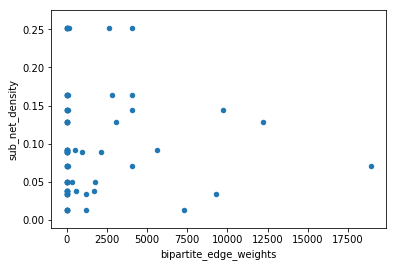

In [117]:
merged.plot('bipartite_edge_weights','sub_net_density', kind='scatter');

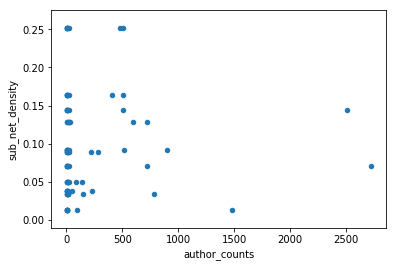

In [118]:
merged.plot('author_counts','sub_net_density', kind='scatter');

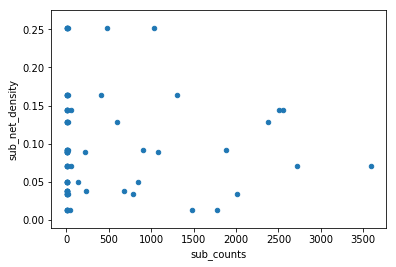

In [119]:
merged.plot('sub_counts','sub_net_density', kind='scatter');

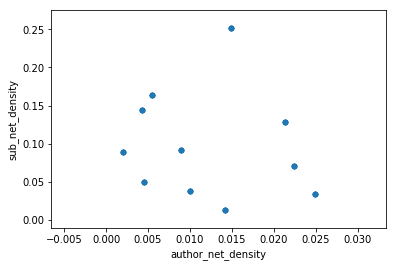

In [120]:
merged.plot('author_net_density','sub_net_density', kind='scatter');

In [15]:
path = str(cache_file('*_stats_df.pkl'))
files = glob.glob(path)

completed = [file.replace(str(cache_file('')), '').replace('_stats_df.pkl', '').lstrip('/') for file in files]

In [16]:
len(completed)

13

In [17]:
completed

['OopsDidntMeanTo',
 'finance',
 'subaru',
 'RelayForReddit',
 'spotify',
 'vegas',
 'whatsthisplant',
 'Christianity',
 'brasil',
 'EarthPorn',
 'pakistan',
 'FoodPorn',
 'StarWars']

In [42]:
from sqlalchemy import create_engine

name=str(cache_file('stats_df.db'))
engine = create_engine('sqlite://', echo=False)
stats_df.to_sql(name=name, con=engine)

In [45]:
test = pd.read_sql(str(cache_file('stats_df.db')), con=engine)

In [46]:
test

,stat,author_counts,author_net_density,bipartite_edge_weights,sub_counts,sub_net_density,subreddit
0,count,592.000000,0.021366,12189.000000,2382.000000,0.128146,OopsDidntMeanTo
1,mean,20.589527,0.021366,12.604644,5.117128,0.128146,OopsDidntMeanTo
2,std,35.136409,0.021366,47.350986,18.797181,0.128146,OopsDidntMeanTo
3,min,1.000000,0.021366,3.000000,1.000000,0.128146,OopsDidntMeanTo
4,25%,7.000000,0.021366,3.000000,1.000000,0.128146,OopsDidntMeanTo
5,50%,14.000000,0.021366,5.000000,1.000000,0.128146,OopsDidntMeanTo
6,75%,26.000000,0.021366,10.000000,3.000000,0.128146,OopsDidntMeanTo
7,max,723.000000,0.021366,3086.000000,592.000000,0.128146,OopsDidntMeanTo
